In [1]:
%%capture
!pip install bertopic

In [2]:
import pandas as pd

In [26]:
import nltk

# 下载 NLTK 停用词
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))


# 3. 文本预处理函数
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    return ' '.join([word for word in words if word not in stop_words])

data = pd.read_csv('abcnews-date-text.csv', nrows=50000)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
data.head()

publish_date                                      headline_text
0      20030219  aba decides against community broadcasting lic...
1      20030219     act fire witnesses must be aware of defamation
2      20030219     a g calls for infrastructure protection summit
3      20030219           air nz staff in aust strike for pay rise
4      20030219      air nz strike to affect australian travellers

In [28]:
# Create a new column containing the length each headline text
data["headline_text_len"] = data["headline_text"].apply(lambda x : len(x.split()))

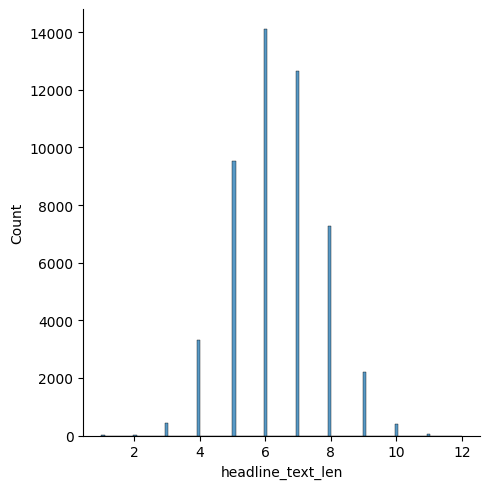

In [7]:
# Visualize the length distribution
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(data.headline_text_len, kde=False)

In [8]:
from bertopic import BERTopic

In [9]:
model = BERTopic(verbose=True,embedding_model='paraphrase-MiniLM-L3-v2',
                 min_topic_size= 50)

In [10]:
headline_topics, _ = model.fit_transform(data.headline_text)

2024-12-20 20:28:56,987 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

2024-12-20 20:31:35,683 - BERTopic - Embedding - Completed ✓
2024-12-20 20:31:35,685 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-20 20:33:00,863 - BERTopic - Dimensionality - Completed ✓
2024-12-20 20:33:00,868 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-20 20:33:14,298 - BERTopic - Cluster - Completed ✓
2024-12-20 20:33:14,338 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-20 20:33:15,345 - BERTopic - Representation - Completed ✓


In [11]:
# 获取主题信息
freq = model.get_topic_info()

# 选择前 10 个主题
top_n = 10
top_topics = freq.head(top_n)

# 输出每个主题的信息
for index, row in top_topics.iterrows():
    topic_id = row['Topic']
    topic_words = model.get_topic(topic_id)

    # 获取前 10 个单词
    top_words = [word for word, _ in topic_words[:10]]

    # 计算每个主题的标题数量
    headline_count = sum(1 for t in headline_topics if t == topic_id)

    print(f"Topic {topic_id}:")
    print(f"Top 10 words: {top_words}")
    print(f"Number of headlines: {headline_count}\n")

Topic -1:
Top 10 words: ['to', 'for', 'of', 'in', 'on', 'over', 'iraq', 'govt', 'council', 'us']
Number of headlines: 22595

Topic 0:
Top 10 words: ['health', 'doctors', 'hospital', 'care', 'medicare', 'aged', 'cancer', 'medical', 'nurses', 'indemnity']
Number of headlines: 1428

Topic 1:
Top 10 words: ['lions', 'crows', 'bulldogs', 'sharks', 'roosters', 'broncos', 'tigers', 'eagles', 'knights', 'cowboys']
Number of headlines: 1143

Topic 2:
Top 10 words: ['fire', 'bushfire', 'firefighters', 'blaze', 'bushfires', 'fires', 'under', 'arson', 'house', 'inquiry']
Number of headlines: 896

Topic 3:
Top 10 words: ['market', 'dollar', 'amp', 'profit', 'ords', 'shares', 'stocks', 'wall', 'rates', 'confidence']
Number of headlines: 738

Topic 4:
Top 10 words: ['crash', 'accident', 'car', 'plane', 'dies', 'killed', 'injured', 'helicopter', 'hospital', 'dead']
Number of headlines: 638

Topic 5:
Top 10 words: ['iraq', 'iraqi', 'baghdad', 'us', 'iraqis', 'forces', 'marines', 'basra', 'troops', 'war

In [12]:
model.visualize_hierarchy(top_n_topics=10)

In [13]:
%%bash
mkdir './model_dir'

mkdir: cannot create directory ‘./model_dir’: File exists


CalledProcessError: Command 'b"mkdir './model_dir'\n"' returned non-zero exit status 1.

In [14]:
# Save the model in the previously created folder with the name 'my_best_model'
model.save("./model_dir/my_best_model")

# Load the serialized model
my_best_model = BERTopic.load("./model_dir/my_best_model")
my_best_model

2024-12-20 20:33:52,647 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

2024-12-20 20:41:07,483 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-12-20 20:41:40,126 - BERTopic - Dimensionality - Completed ✓
2024-12-20 20:41:40,128 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-12-20 20:41:50,154 - BERTopic - Cluster - Completed ✓


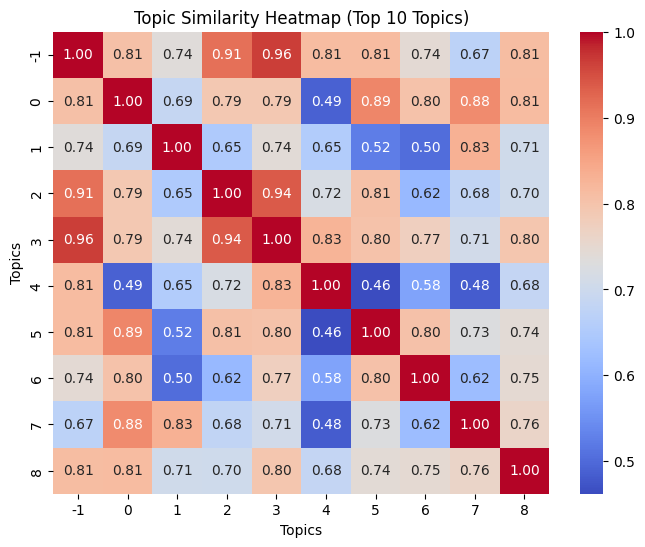

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bertopic import BERTopic
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import re

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

# 1. Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    return ' '.join([word for word in words if word not in stop_words])

# 2. Load the dataset
data = pd.read_csv('abcnews-date-text.csv', nrows=50000)

# 3. Apply text preprocessing
data['headline_text'] = data['headline_text'].apply(preprocess_text)

# 4. Load the previously saved BERTopic model
my_best_model = BERTopic.load("./model_dir/my_best_model")

# 5. Transform the headlines using the loaded model
headline_topics, _ = my_best_model.transform(data['headline_text'])

# 6. Get topic information
topic_info = my_best_model.get_topic_info().head(10)

# 7. Get topic representations (if available)
topic_representations = [my_best_model.get_topic(i) for i in topic_info['Topic']]

# 8. Generate random embeddings for demonstration (replace with actual embeddings if needed)
d_embeddings = np.random.rand(10, 10)

# 9. Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(d_embeddings)

# 10. Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=topic_info['Topic'], yticklabels=topic_info['Topic'])
plt.title('Topic Similarity Heatmap (Top 10 Topics)')
plt.xlabel('Topics')
plt.ylabel('Topics')
plt.show()

In [17]:
pip install gensim

In [18]:
import pandas as pd
from bertopic import BERTopic
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import os
import nltk
import re

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    return ' '.join([word for word in words if word not in stop_words])

# Define the file path for the model
model_path = "./model_dir/my_best_model"

# Load dataset
data_url = "abcnews-date-text.csv"
data = pd.read_csv(data_url, nrows=50000)

# Rename the column for consistency
data = data.rename(columns={'headline_text': 'text'})

# Apply text preprocessing
data['text'] = data['text'].apply(preprocess_text)

# Check if the model exists; if not, initialize and fit the BERTopic model
if os.path.exists(model_path):
    # Load the serialized model
    my_best_model = BERTopic.load(model_path)
else:
    # Initialize and fit the BERTopic model
    my_best_model = BERTopic(verbose=True, embedding_model='paraphrase-MiniLM-L3-v2', min_topic_size=50)
    headline_topics, _ = my_best_model.fit_transform(data['text'])

    # Save the model
    my_best_model.save(model_path)

# Get topics and their words
topics = my_best_model.get_topics()
topic_words = [[word for word, _ in topics[topic]] for topic in topics.keys()]

# Create Dictionary
texts = [headline.split() for headline in data['text'].tolist()]
dictionary = Dictionary(texts)

# Calculate coherence score
coherence_model = CoherenceModel(topics=topic_words, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

print(f"Data Coherence: {coherence_score}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data Coherence: 0.36049596471454326


In [19]:
# Data Diversity Function
def calculate_diversity(topic_words):
    unique_words = set()
    total_words = 0

    for words in topic_words:
        unique_words.update(words)
        total_words += len(words)

    diversity_score = len(unique_words) / total_words if total_words > 0 else 0
    return diversity_score

# Calculate and print the diversity score
diversity_score = calculate_diversity(topic_words)
print(f"Data Diversity: {diversity_score:.4f}")

Data Diversity: 0.8490
